In [1]:
"""
Implementation of mean-reversion strategy with absolute price oscillator while dynamically adjusting for volatility
"""

'\nImplementation of mean-reversion strategy with absolute price oscillator while dynamically adjusting for volatility\n'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import math as math
from pandas_datareader import data


In [3]:
# we load the dataset 
# we use the same dataset for comparison
try:
    data_amzn = pd.read_pickle('amzn_data.pkl')
except:
    data_amzn = data.DataReader("AMZN",'yahoo','2015-01-01','2020-01-01')
    data_amzn.to_pickle('amzn_data.pkl')
data_amzn

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,15.737500,15.348000,15.629000,15.426000,55664000,15.426000
2015-01-05,15.419000,15.042500,15.350500,15.109500,55484000,15.109500
2015-01-06,15.150000,14.619000,15.112000,14.764500,70380000,14.764500
2015-01-07,15.064000,14.766500,14.875000,14.921000,52806000,14.921000
2015-01-08,15.157000,14.805500,15.016000,15.023000,61768000,15.023000
...,...,...,...,...,...,...
2019-12-24,89.778503,89.378998,89.690498,89.460503,17626000,89.460503
2019-12-26,93.523003,89.974998,90.050499,93.438499,120108000,93.438499
2019-12-27,95.070000,93.300499,94.146004,93.489998,123732000,93.489998


<AxesSubplot:xlabel='Date'>

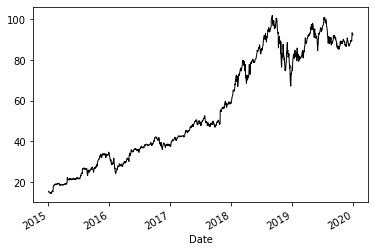

In [4]:
# before the preparation, we just observe the dataset first
data_amzn['Close'].plot(color = 'k',lw = 1)

1.5388011500701388

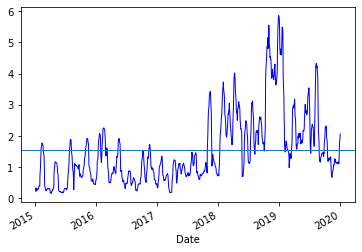

In [5]:
# then we check the total standard deviation
data_amzn['Close'].rolling(window = 20, min_periods = 1).std().plot(color = 'b',lw = 1)
total_mean = np.mean(data_amzn['Close'].rolling(window = 20, min_periods = 1).std())
plt.axhline(total_mean,lw = 1)
total_mean

# for convenience, even the mean_std = 1.5388011500701388, we will use 1.54
# 1.54 will be the standard we use to assess the volatility

In [6]:
# for the preparation, it is the same as the strategy without adjustment
# define the window_size for fast_ema and slow_ema
# for fast_ema, it is 10 days
fast = 10
k_fast = 2 / (fast+1)
ema_fast = 0
ema_fast_values = []

slow = 40 # 40 days for slow_ema
k_slow = 2 / (slow+1)
ema_slow = 0
ema_slow_values = []
apo_values = [] # we save it for buying / selling signals

In [7]:
# we save some variables for storing orders, positions, and profit & loss
orders = [] 
# -1: sell order
# 1: buy order
# 0: neutral

positions = []
# -1: short
# 1: long
# 0: netural

# open value - closed value
# sum of open pnl and closed pnl (lock-in profits - realized)
pnls = []

# we record the last buy/sell price to prevent overtrading
# we don't want to buy/sell just around the last buy/sell trade to ensure profits
last_buy_price = 0
last_sell_price = 0

# current position
position = 0

# summation quantity since last no position
buy_sum_qty = 0
sell_sum_qty = 0

buy_sum_price_qty = 0
sell_sum_price_qty = 0

# record open and closed pnls
open_pnls = 0
closed_pnls = 0

In [8]:
# we set up threshold for enter positions and the minimum price change since the last trade
apo_buy_entry = -5
apo_sell_entry = 5
min_price_movement = 5 # we use it prevent overtrading
num_shares = 10 # number of shares we will buy/sell at each trade
min_profit_to_close = 5*num_shares # if the profits > 5, regardless of apo, we exit the position


In [9]:
# now, we slighly modify the way we calculate ema
# we use std /  * k_fast / k_slow as the real factor
# we need a simple moving average for updating the standard deviation
# and we define the periods to be 20 days
sma_periods = 20
price_history = []

In [10]:
close = data_amzn['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > sma_periods:
        # we delete the first element to update the std
        del(price_history[0])
    
    # we calculate the variance
    sma = stats.mean(price_history)
    variance = 0
    for temp_price in price_history:
        variance += (temp_price - sma)**2
    
    std = (variance / len(price_history)) ** (0.5)
    # here, we define the std_factor as:
    # std_factor = std / 1.10
    std_factor = std / 1.538
    # if std_factor = 0, for our later calculation, we just set it to 1
    if std_factor == 0:
        std_factor = 1
    
    # we check whether the data is the first observation
    if ema_fast == 0:
        ema_fast = close_price
        ema_slow = close_price
    else:
        # we use our std_factor here
        ema_fast = k_fast*std_factor*close_price + (1-k_fast*std_factor)*ema_fast
        ema_slow = k_slow*std_factor*close_price + (1-k_slow*std_factor)*ema_slow
    
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    
    # calculate apo
    apo = ema_fast - ema_slow
    apo_values.append(apo)
    
    
    # now we consider std_factor in the conditions of our buy / sell actions
    if (apo > apo_sell_entry * std_factor and abs(close_price - last_sell_price) > min_price_movement * std_factor) \
    or (position > 0 and (apo >= 0 or open_pnls > min_profit_to_close / std_factor)):
        # why we multipy std_factor for the first condition: because now we are considering whether to enter a position
        # smaller std_factor ---> smaller volatility, meaning that we are likely to enter the position
        
        # why do we divide std_factor for the second condition:
        # we tend to leave with larger volatility
        orders.append(-1)
        last_sell_price = close_price
        position -= num_shares
        sell_sum_qty += num_shares
        sell_sum_price_qty += num_shares*close_price
        print("Sell ",num_shares, "@",close_price)
        print("Position:",position)
    # we apply the same logic to buy order
    elif (apo < apo_buy_entry * std_factor and abs(close_price - last_buy_price) > min_price_movement * std_factor) \
    or (position < 0 and (apo <= 0 or open_pnls > min_profit_to_close / std_factor)):
        orders.append(1)
        last_buy_price = close_price
        position += num_shares
        buy_sum_qty += num_shares
        buy_sum_price_qty += num_shares*close_price
        print("Buy ",num_shares, "@",close_price)
        print("Position:",position)
    else: # flat position
        orders.append(0)
    positions.append(position)
    
    # for open_pnls, it is the same as the original strategy
    open_pnls = 0
    
    if position > 0:
        # we need to minus some closed pnls if position > 0 but sell_qty > 0
        # because that means our position is long, but we have done some selling against this trade
        # we will minus the closed pnls
        if sell_sum_qty > 0:
            # we use an average price difference for calculation
            open_pnls += sell_sum_qty*(sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        # then we set the remaining to open pnls with respect to market price
        
        # why do we use (sell_sum_qty - buy_sum_qty): we want the unrealized buy_sum_qty
        # why do we use (close_price - buy_sum_price / buy_sum_qty):
        # because we want to calculate the profits if we close at current price
        # we want to sell at close_price because we have long position
        open_pnls += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    
    # we now look at the case for short position
    elif position < 0:
        # that means we have some realized buy orders
        if buy_sum_qty > 0:
            open_pnls += buy_sum_qty * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
        
        # we want to calculate the unrealized buy open pnls
        
        # why do we use (sell_sum_price_qty / sell_sum_qty-open_price):
        # now out position is short, and we want to buy back at the current open_price 
        open_pnls += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty-close_price)
    else:
        # the position is 0, we just update close_pnls
        # open_pnls is 0. we can directly use sell_sum_price_qty - buy_sum_price_qty
        closed_pnls += (sell_sum_price_qty - buy_sum_price_qty)
        
        # and we reset the sum_price_qty 
        buy_sum_price_qty = 0
        sell_sum_price_qty = 0
        
        buy_sum_qty = 0
        sell_sum_qty = 0
        
        last_buy_price = 0
        last_sell_price = 0
    print("OpenPnL: ", open_pnls, " ClosedPnL: ", closed_pnls)
    print("Totl PnL:",closed_pnls+open_pnls)
    pnls.append(closed_pnls+open_pnls)
    

OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  0
Totl PnL: 0
OpenPnL:  0  ClosedPnL:  

OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  -260.90999603271484
Totl PnL: -260.90999603271484
OpenPnL:  0  ClosedPnL:  

OpenPnL:  0  ClosedPnL:  -206.77494049072266
Totl PnL: -206.77494049072266
OpenPnL:  0  ClosedPnL:  -206.77494049072266
Totl PnL: -206.77494049072266
OpenPnL:  0  ClosedPnL:  -206.77494049072266
Totl PnL: -206.77494049072266
OpenPnL:  0  ClosedPnL:  -206.77494049072266
Totl PnL: -206.77494049072266
Sell  10 @ 42.650001525878906
Position: -10
OpenPnL:  0.0  ClosedPnL:  -206.77494049072266
Totl PnL: -206.77494049072266
OpenPnL:  0.2700042724609375  ClosedPnL:  -206.77494049072266
Totl PnL: -206.50493621826172
OpenPnL:  -0.79498291015625  ClosedPnL:  -206.77494049072266
Totl PnL: -207.5699234008789
OpenPnL:  0.23502349853515625  ClosedPnL:  -206.77494049072266
Totl PnL: -206.5399169921875
OpenPnL:  0.0150299072265625  ClosedPnL:  -206.77494049072266
Totl PnL: -206.7599105834961
OpenPnL:  -0.20999908447265625  ClosedPnL:  -206.77494049072266
Totl PnL: -206.9849395751953
OpenPnL:  0.345001220703125  ClosedPnL:  -206.77494049072266
Totl PnL: -206.42993927001953
OpenPnL:  -1.9849777221679688 

OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  

OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  -318.01998138427734
Totl PnL: -318.01998138427734
OpenPnL:  0  ClosedPnL:  

In [11]:
# now we want to visualize the result
data_amzn['Fast_EMA'] = pd.Series(ema_fast_values,index = data_amzn.index)
data_amzn['Slow_EMA'] = pd.Series(ema_slow_values,index = data_amzn.index)
data_amzn['APO'] = pd.Series(apo_values,index = data_amzn.index)
data_amzn['Orders'] = pd.Series(orders,index = data_amzn.index)
data_amzn['Position'] = pd.Series(positions,index = data_amzn.index)
data_amzn['PnL'] = pd.Series(pnls,index = data_amzn.index)
data_amzn['APO']

Date
2015-01-02    0.000000
2015-01-05   -0.004332
2015-01-06   -0.019614
2015-01-07   -0.029654
2015-01-08   -0.036365
                ...   
2019-12-24    0.328846
2019-12-26    0.898904
2019-12-27    1.424422
2019-12-30    1.646078
2019-12-31    1.804584
Name: APO, Length: 1258, dtype: float64

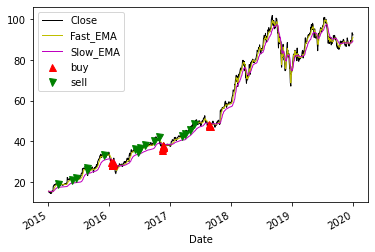

In [12]:
data_amzn['Close'].plot(color = 'k',lw = 1)
data_amzn['Fast_EMA'].plot(color = 'y',lw = 1)
data_amzn['Slow_EMA'].plot(color = 'm',lw = 1)
# we show our order
plt.plot(data_amzn.loc[data_amzn.Orders == 1].index, data_amzn.Close[data_amzn.Orders == 1],lw = 0,label = 'buy', markersize = 7,marker = '^',color = 'r')
plt.plot(data_amzn.loc[data_amzn.Orders == -1].index, data_amzn.Close[data_amzn.Orders == -1],lw = 0,label = 'sell', markersize = 7,marker = 'v',color = 'g')
plt.legend()

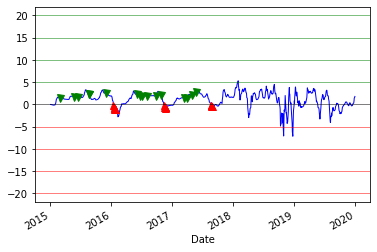

In [13]:
# we also display the apo values and buy/sell orders
data_amzn['APO'].plot(color ='b',lw = 1)
plt.plot(data_amzn.loc[data_amzn.Orders == 1].index, data_amzn.APO[data_amzn.Orders == 1],color = 'r',marker = '^',markersize = 7,lw = 0, label = 'buy')
plt.plot(data_amzn.loc[data_amzn.Orders == -1].index, data_amzn.APO[data_amzn.Orders == -1],color = 'g',marker = 'v',markersize = 7,lw = 0, label = 'sell')

# we draw some horizontal lines to see where to buy and where to sell more clearly
plt.axhline(y = 0, lw = 0.5, color = 'k')

for i in range(apo_buy_entry, apo_buy_entry*5,apo_buy_entry):
    plt.axhline(y = i,lw = 0.5, color = 'r')

    
for i in range(apo_sell_entry, apo_sell_entry*5,apo_sell_entry):
    plt.axhline(y = i,lw = 0.5, color = 'g')

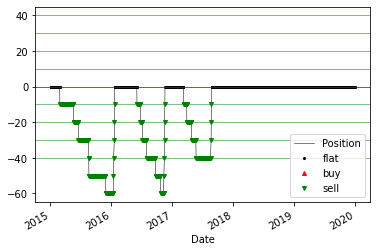

In [14]:
data_amzn['Position'].plot(color = 'k',lw = 0.5)
plt.plot(data_amzn[data_amzn.Position == 0].index, data_amzn.Position[data_amzn.Position == 0],marker = '.',markersize = 4,color = 'k',lw = 0, label = 'flat')
plt.plot(data_amzn[data_amzn.Position > 0].index, data_amzn.Position[data_amzn.Position >0],marker = '^',markersize = 4,color = 'r',lw = 0, label = 'buy')
plt.plot(data_amzn[data_amzn.Position < 0].index, data_amzn.Position[data_amzn.Position <0],marker = 'v',markersize = 4,color = 'g',lw = 0, label = 'sell')

plt.axhline(y = 0, lw = 0.5, color = 'k')

for i in range(num_shares, num_shares*5,num_shares):
    plt.axhline(y = i,lw = 0.5, color = 'r')

for i in range(0, -num_shares*5,-num_shares):
    plt.axhline(y = i,lw = 0.5, color = 'g')
    
plt.legend()

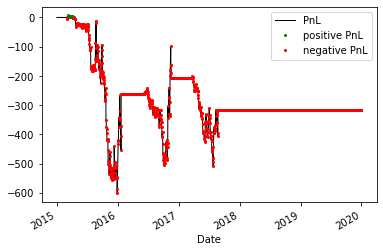

In [15]:
data_amzn['PnL'].plot(color = 'k',lw = 1)
# green represents positive pnl
plt.plot(data_amzn[data_amzn.PnL > 0].index, data_amzn.PnL[data_amzn.PnL> 0],marker = '.',color = 'g',lw = 0,markersize = 4,label = 'positive PnL')
plt.plot(data_amzn[data_amzn.PnL < 0].index, data_amzn.PnL[data_amzn.PnL< 0],marker = '.',color = 'r',lw = 0,markersize = 4,label = 'negative PnL')
plt.legend()

In [16]:
# ... it is quite interesting to see that we loss more after using volatility adjusted
# especialy after several times I changed the parameters of the time periods of sma, std, fast_ema, slow_ema
# I will revisit it soon to explain this discrepancy